# Exercise 2

## Tweakable Block Ciphers

Este tipo de cifra é diferente das normais PBC dada a utilização de um parâmetro adicional que conhecemos como tweak.

O tweak é interessante pois permite adicionar uma forma unica de identificar cada bloco cifrado, isto evita ataques por repetição de blocos. Assim, a concatenação da chave *k* com o tweak *w* atribui ao bloco uma nova chave a que chamamos **tweaked key**.

<div class="alert alert-block alert-info">
<b>Note:</b> Existem duas formas de usar os tweaks, a explicada em cima é a maneira mais básica e usada nas cifras lightweigth. A outra forma passa por usar o tweak para modificar o plaintext.
</div>

Podemos definir a tweaked key como:
$$ κ ≡ w ∥ k $$

Então:
$$ E(w, k, x) ≡ E(κ, x) $$

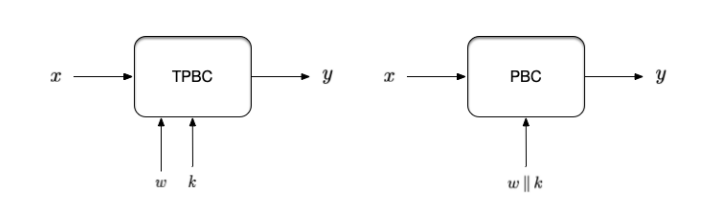

### Tipos e construção dos tweaks

Existem dois tipos de tweaks

$$ w_i = nounce  ∥  i  ∥  0 $$
$$ w^* = nounce  ∥  l  ∥  1 $$

Em que: 
- $nounce $ é um numero pseudo-aleatório que será o mesmo para todos os blocos;\
- $ i $  é um contador incrementado a cada bloco do plaintext;\
- $ l $  é o tamanho do plaintext completo.

Todos os 3 elementos mencionados em cima têm: $$ tamanho = blockSize/2$$ 

Como podemos ver, além do $l$ e do $i$ estes tweaks podem ainda ser distinguidos pelo ultimos bit, que representa se são um tweak usado na cifragem do plaintext - $w_i$ ou usados para gerar a tag de autenticação - $w^*$.


A baixo está representado o nosso algoritmo para calcular os diferentes tweaks, este segue exatamente a lógica explicada em cima, recebendo como argumento o plaintext, um nounce e uma variável responsável por identificar o tipo de tweak que vai ser calculado.

```python
def tweak_generator(plaintext, nonce, auth):
    wi = []  
    w_auth = None  

    block_size = 16

    blocks = [plaintext[i:i+block_size] for i in range(0, len(plaintext), block_size)]
    num_blocks = len(blocks)

    if auth == 0:
        for i in range(num_blocks):
            tweak = nonce
            tweak += i.to_bytes(8, 'big')
            tweak += b'\x00'
            wi.append(tweak)
        return wi

    elif auth == 1:
        tweak = nonce
        tweak += len(plaintext).to_bytes(8, 'big')
        tweak += b'\x01'
        w_auth = tweak
        return w_auth
    
```

Após gerado o tweak, podemos então calcular a nossa **tweaked key**, que será usada para cifrar o nosso plaintext.

```python
def derive_key(key, tweak):
    input_key_material = key + tweak

    hkdf = HKDF(
        algorithm=hashes.SHA256(),
        length=16, 
        salt=None,
        info=b'tbc128_encrypt'
    )
    tkey = hkdf.derive(input_key_material)
    
    return tkey
```
Dada a primitiva utilizada pelo TBC, a chave tem que ter exatamente 16 bytes. Para garantirmos que a chave é do tamanho desejado usamos o SHA256 como função de hash no HKDF.



## AES-128 em modo ECB

O **AES-128 no modo ECB** é um método simples de cifragem onde cada bloco de 128 bits do plaintext é cifrado de forma independente usando a chave AES-128. No entanto, o modo ECB apresentava vulnerabilidades, pois se houvesse padrões no plaintext eles seriam reproduzidos no ciphertext o que comprometeria a segurança das mensagens.

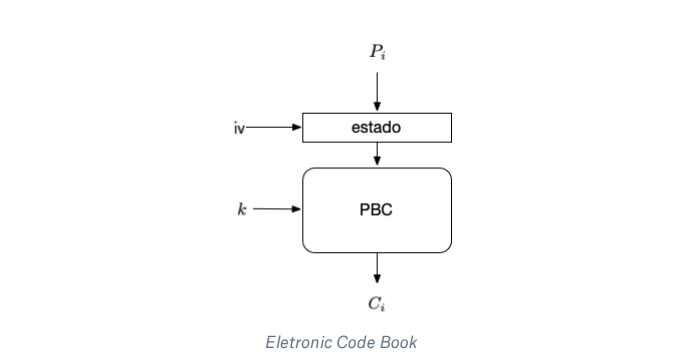

```python
    cipher = Cipher(algorithms.AES(derived_key), modes.ECB())
    encryptor = cipher.encryptor() 
    ciphertext = encryptor.update(plaintext) 
    return ciphertext
```

Para mitigar alguns dos problemas deste metodo usamos os **tweaks**. Eles introduzem "aleatoriedade", evitando padrões visíveis e tornando o ciphertext mais seguro. Com os tweaks, a cifra torna-se "tweakable", ou seja, capaz de gerar diferentes ciphertexts mesmo para o mesmo plaintext. Isso melhora a confidencialidade e elimina algumas das falhas de segurança associadas ao modo ECB.

## O modo TAE  (Tweaked Authentication Encryption)


Este modo tem essencialmente 3 partes

#### 1ª parte:

Supondo que o plaintext pode ser dividido em $m$ blocos:

- Vamos cifrar os primeiros $m$ blocos (desde o bloco 0 até ao bloco $m - 1$) usando uma TPBC com parametros $k $ e $w_i$ , em que $k$ é o mesmo para os $m$ blocos, mas $w_i$ é diferente para cada um deles



```python
def tae_encrypt(key, nounce, plaintext, ad):
    block_size = 16

    padded_plaintext = add_padding(plaintext, block_size)
    
    plaintext_blocks = [padded_plaintext[i:i+block_size] for i in range(0, len(padded_plaintext), block_size)]

    wi = tweak_generator(padded_plaintext, nounce, auth=0)
    

    ciphertext_blocks = []
    for i, block in enumerate(plaintext_blocks[:-1]):
        ciphertext_block = tbc128_encrypt(key, wi[i], block)
        ciphertext_blocks.append(ciphertext_block)

    ...
```

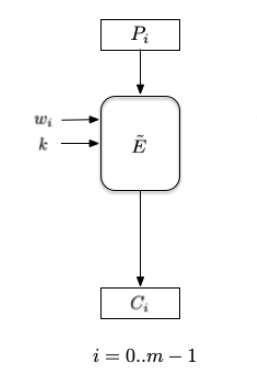

#### 2ª parte:

Como visto em cima, foi deixado um bloco por cifrar - $P_m $.\
Este ultimo bloco é cifrado a partir de um XOR entre ele e uma máscara do valor correspondente ao tamanho do ultimo bloco - $τ$.

```py
    last_block = plaintext_blocks[-1]
    tau = len(last_block).to_bytes(block_size, 'big')

    mask = tbc128_encrypt(key, wi[-1], tau)

    pm_cipher = bytes([mask[i] ^ last_block[i] for i in range(len(last_block))])
    ciphertext_blocks.append(pm_cipher)
    ...
``` 

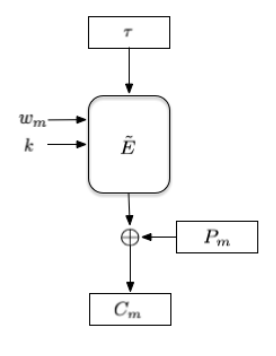

#### 3ª parte:

A ultima parte do processo consiste em gerar a tag de autenticação.\
Esta é calculada da seguinte forma:
- Calcula-se a paridade do plaintext
- Gera-se o tweak de autenticação que será usado para criar a tweaked key
- Cifra-se a paridade do plaintext usando tweaked key gerando a tag

```python
    parity = 0
    for byte in padded_plaintext:
        parity ^= byte
    parity = parity.to_bytes(16, 'big')

    w_auth = tweak_generator(padded_plaintext, nounce, auth=1)
    
    tag = tbc128_encrypt(key, w_auth, parity)
    return ciphertext, tag

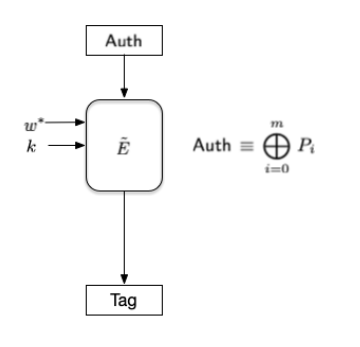

## Canal privado de informação com acordo de chaves

#### X25519 Key Exchange

O X25519 key exchange é um protocolo de troca de chaves baseado em curvas elípticas.
O X25519 utiliza a curva elíptica Curve25519:
$$y^2 =x^3+486662x^2+x $$

Este implementa uma variante do protocolo Diffie-Hellman para curvas elípticas,permitindo que duas partes gerem uma chave secreta compartilhada sem nunca transmitirem a chave diretamente

##### Como são geradas as chaves:

- O Agente A gera um par de chaves:
    - Chave privada:  $a$ (numero pseudo-aleatório de 256 bits)
    - Chave pública: $A = a ⋅ G$ 

- O Agente A gera um par de chaves:
    - Chave privada:  $b$
    - Chave pública: $B = b ⋅ G$ 


```python
        x25519_private, x25519_public = generate_x25519_key_pair()
```
    
##### Como são trocadas as chaves:

- O Agente A envia a sua chave pública $A$ para o Agente B
- O Agente B envia a sua chave pública $B$ para o Agente A

```python
        client_socket.send(x25519_public_bytes)
        peer_x25519_public_bytes = client_socket.recv(32)
```
- O agente A calcula a chave compatilhada $S = a ⋅ B$
- O agente B calcula a chave compatilhada $S = b ⋅ A$

```python
        shared_key = derive_shared_key(x25519_private, peer_x25519_public)
```
- Os agentes derivam uma chave simétrica usando HKDF

```python
        derived_key = hkdf_derive_key(shared_key)
```


#### Ed25519 Signing&Verification

O Ed25519 é um esquema de assinaturas digitais baseado na mesma curva do X25519 para autenticar as partes envolvidas na troca de chaves, garantindo que o canal estabelecido é seguro.

```python
        ed25519_private, ed25519_public = generate_ed25519_key_pair()
```

- O Agente A assina a sua chave pública $A$ com a sua chave privada Ed25519 e envia a assinatura para o Agente B
- O Agente B assina a sua chave pública $B$ com a sua chave privada Ed25519 e envia a assinatura para o Agente A

```python
        signed_public_key = sign_data(ed25519_private, x25519_public_bytes) 
```

- O Agente B confirma a assinatura de $A$ usando a chave pública Ed25519 do Agente A.
- O Agente A confirma a assinatura de $B$ usando a chave pública Ed25519 do Agente B.

```python 
        peer_x25519_public = X25519PublicKey.from_public_bytes(peer_x25519_public_bytes)
        peer_ed25519_public = Ed25519PublicKey.from_public_bytes(peer_ed25519_public_bytes)
```


- Os agentes verificam as assinaturas

```python
    if not verify_signature(peer_ed25519_public, peer_signature, peer_x25519_public_bytes):
        raise ValueError("Assinatura do outro agente inválida!")
    else:
        print(f"{role}: Assinatura verificada com sucesso!")
```



### Envio e receção de mensagens

O envio e mensagens de um agente para o outro acontece de maneira bidirecional, isto é, tanto o que começa a comunicação como o que a recebe consegue enviar ou receber mensagens.
- A mensagem é cifrada usando a cifra TAE com a chave derivada e um nonce. Depois de cifrada, tanto a mensagem como o nonce e a tag são enviados para o outro agente.
- Quando recebe o ciphertext este é decifrado usando a chave derivada calculada durante a troca de chaves

```python
    def receive_messages():
        while True:
            ciphertext = client_socket.recv(1024)
            if not ciphertext:
                break
            nonce = client_socket.recv(8)
            tag = client_socket.recv(16)
            associated_data = b"Dados associados"

            plaintext = tae_decrypt(derived_key, nonce, ciphertext, associated_data, tag)
            print(f"{role}: Mensagem recebida: {plaintext.decode()}")

    def send_messages():
        while True:
            message = input(f"{role}: Envia uma mensagem: ")
            nonce = os.urandom(8)
            associated_data = b"Dados associados"
            ciphertext, tag = tae_encrypt(derived_key, nonce, message.encode(), associated_data)

            client_socket.send(ciphertext)
            client_socket.send(nonce)
            client_socket.send(tag)
```